In [2]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

%matplotlib inline  

import sys
import matplotlib as mpl

import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm_notebook as tqdm

# Set random seed so output is all same
np.random.seed(1)

# url for image in KMeans
url = 'https://zbigatron.com/wp-content/uploads/2019/09/grumpy_cat.jpg'

from sklearn.mixture import GaussianMixture
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold

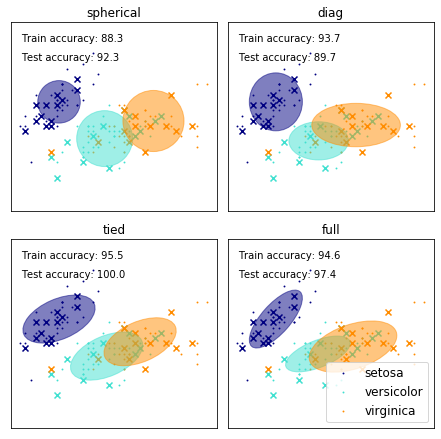

In [3]:
colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()


Fitting model on a small sub-sample of the data
(1000, 3) (273280, 3)
done in 0.568s.
Predicting color indices on the full image (k-means)
done in 0.393s.
(64, 3)
Predicting color indices on the full image (random)
done in 0.479s.


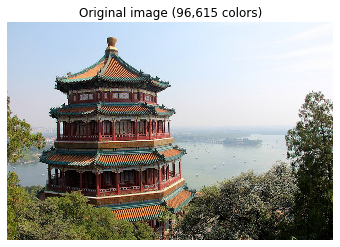

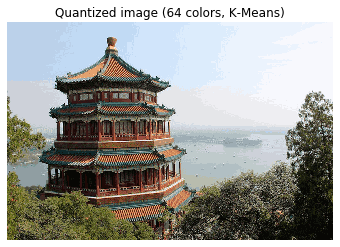

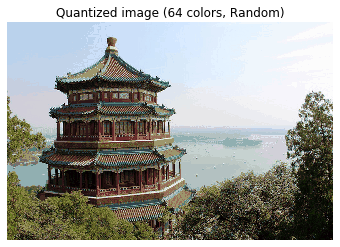

In [39]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 64

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
print(image_array_sample.shape, image_array.shape)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print(codebook_random.shape)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

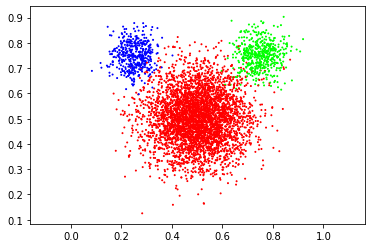

In [32]:

def plot_scatter(samples, ids):
    colors = np.zeros((len(ids), 3))
    choices = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    num_points = []
    for i in range(3):
        num_points.append(np.sum(ids == i))
    maps = np.argsort(num_points)
    for i in range(3):
        colors[np.where(ids == maps[i]), :] = choices[i]
    plt.scatter(samples[:, 0], samples[:, 1], s=1, color=colors)
    plt.axis('equal')
def gmm_sampling(num_samples, pi, mu, sigma):
    """
    Args:
        num_samples: number of samples required
        pi: np array of length K, the prior distribution, where K is # components
        mu: KxD np array, the center for each gaussian, where D is data dimension
        sigma: KxDxD np array, the standard deviation cov for each gaussian
    Return:
        samples: NxD np array, the result samples
        ids: np array of length N, the component id for each sample
    """    
    # obtain the shapes
    K = mu.shape[0]  # nb of components (pi)
    D = mu.shape[1]  # data dimension
    N = num_samples

    samples = np.zeros((N,D))
    ids = np.zeros(N)

    for i in range(0,N):
        # choose component
        r = np.random.uniform(0,1)
        if r <= pi[0]:
            index = 0
        elif r <= pi[0]+pi[1]:
            index = 1
        else:
            index = 2
        ids[i] = index

        # sample from Gaussian
        mean = mu[index,:]
        cov = sigma[index,:]**2
        samples[i,:] = np.random.multivariate_normal(mean, cov)

    return samples,ids

pi = np.array([0.8, 0.1, 0.1])
mu = np.array([[0.5, 0.5], 
               [0.25, 0.75], 
               [0.75, 0.75]], dtype=np.float32)
sigma = np.array(
    [
        [[0.1, 0.01],
        [0.01, 0.1]],
        
        [[0.05, 0.01],
        [0.01, 0.05]],
        
        [[0.05, 0.],
        [0., 0.05]]            
    ],)

samples, ids = gmm_sampling(5000, pi, mu, sigma)
plot_scatter(samples, ids)

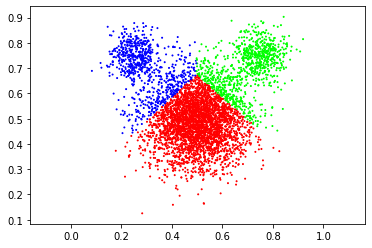

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='random', random_state=0).fit(samples)
ids, centers = kmeans.labels_, kmeans.cluster_centers_
plot_scatter(samples, ids)

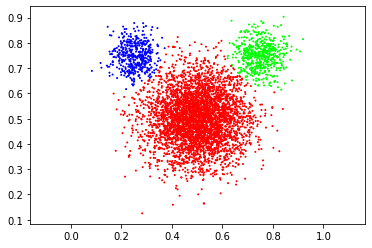

In [35]:
gmm = GaussianMixture(n_components=3).fit(samples)
ids = gmm.predict(samples)
plot_scatter(samples, ids)

In [27]:
# helper function for plotting images. You don't have to modify it

def plot_images(img_list, title_list, figsize=(11, 6)):
    assert len(img_list) == len(title_list)
    fig, axes = plt.subplots(1, len(title_list), figsize=figsize)
    for i, ax in enumerate(axes):
        ax.imshow(img_list[i] / 255.0)
        ax.set_title(title_list[i])
        ax.axis('off')
        
# helper function for plotting images. You don't have to modify it
def cluster_pixels_gmm(image, K, covariance_type='full'):
    """Clusters pixels in the input image
    
    Args:
        image: input image of shape(H, W, 3)
        K: number of components
    Return:
        clustered_img: image of shape(H, W, 3) after pixel clustering
    """
    im_height, im_width, im_channel = image.shape
    flat_img = np.reshape(image, [-1, im_channel]).astype(np.float32)
    # gamma, (pi, mu, sigma) = GMM()(flat_img, K=K, max_iters=100)
    gmm = GaussianMixture(n_components=K, random_state=1, max_iter=200, verbose=2, 
                          covariance_type=covariance_type)
    gmm.fit(flat_img)
    print(gmm)
    gamma = gmm.predict_proba(flat_img)
    cluster_ids = np.argmax(gamma, axis=1)
    centers = gmm.means_
#     cluster_ids = np.argmax(gamma, axis=1)
#     centers = mu
    
    gmm_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))
    
    return gmm_img

Initialization 0
  Iteration 10	 time lapse 1.34428s	 ll change 0.05464
  Iteration 20	 time lapse 0.90357s	 ll change 0.00082
Initialization converged: True	 time lapse 2.24798s	 ll -12.96485
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=1, reg_covar=1e-06, tol=0.001, verbose=2,
                verbose_interval=10, warm_start=False, weights_init=None)


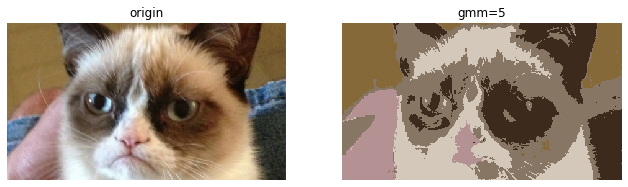

In [28]:
# helper function for plotting images. You don't have to modify it
image = imageio.imread(imageio.core.urlopen(url).read())
gmm_image_5 = cluster_pixels_gmm(image, 5)
plot_images([image, gmm_image_5], ['origin', 'gmm=5'])

Initialization 0
  Iteration 10	 time lapse 4.01317s	 ll change 0.01086
  Iteration 20	 time lapse 2.75209s	 ll change 0.00218
Initialization converged: True	 time lapse 7.84014s	 ll -12.57797
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
                means_init=None, n_components=15, n_init=1,
                precisions_init=None, random_state=1, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)


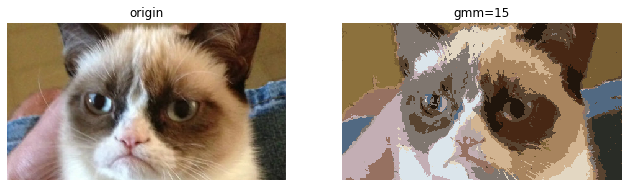

In [29]:
gmm_image_15 = cluster_pixels_gmm(image, 15)
plot_images([image, gmm_image_15], ['origin', 'gmm=15'])

Initialization 0
  Iteration 10	 time lapse 2.49560s	 ll change 0.00324
Initialization converged: True	 time lapse 3.26260s	 ll -13.54485
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=200,
                means_init=None, n_components=15, n_init=1,
                precisions_init=None, random_state=1, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)


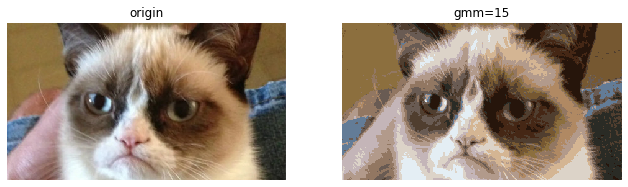

In [30]:
gmm_image_15_diag = cluster_pixels_gmm(image, 15, covariance_type='diag')
plot_images([image, gmm_image_15_diag], ['origin', 'gmm=15'])